# Research Question 3 - Hubs and Authorities

Do authorities within the Reddit-Climate network influence the debate particularly?
- Hypothesis: Yes. We hypothesize that authority redditors - either defined by a high in-degree of comments or by looking into Reddit awards - influence other Redditors in a way related to echo-chambers.

In [1]:
import os
from pathlib import Path
import json
import bz2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
tqdm.pandas()

from collections import Counter

import networkx as nx
from networkx.readwrite import json_graph

import netwulf as nw

In [2]:
def read_json_file(filename):
    with open(filename) as f:
        js_graph = json.load(f)
    return json_graph.node_link_graph(js_graph)

In [33]:
year = 2020
ClimateGraph = read_json_file('/Users/Olivia/Downloads/Reddit-ClimateGraph/data/2020/ClimateGraph_2020.json')

In [237]:
opinion_dict = nx.get_node_attributes(ClimateGraph, 'opinion_score')
awards_dict = nx.get_node_attributes(ClimateGraph, 'total_awards_received')

In [238]:
top = list(zip(*sorted(ClimateGraph.in_degree, key=lambda x: x[1], reverse=True)))
top_authorities, indegree = pd.Series(top[0]), pd.Series(top[1])
top_authorities = top_authorities[indegree > 0][:50]
indegree = indegree[indegree > 0][:50]

authority_indegree, hub_indegree = [], []
for node in top_authorities:
    incoming_neighbors = list(list(zip(*ClimateGraph.in_edges(node)))[0])
    
    hub_opinion = pd.Series([opinion_dict[neighbor_node] for neighbor_node in incoming_neighbors])
    hub_indegree.append(hub_opinion.mean())
    
    authority_indegree.append(opinion_dict[node])


indegree_hub_auth = pd.DataFrame([hub_indegree, authority_indegree, indegree], columns=top_authorities, 
                    index=['hub', 'authority', 'indegree']).T

In [239]:
top = list(zip(*sorted(nx.get_node_attributes(ClimateGraph, 'total_awards_received').items(), key=lambda x: x[1], reverse=True)))
top_authorities, awards = pd.Series(top[0]), pd.Series(top[1])
top_authorities = top_authorities[awards > 0][:50]
awards = awards[awards > 0][:50]

authority_awards, hub_awards = [], []
for node in top_authorities:
    incoming_neighbors = list(list(zip(*ClimateGraph.in_edges(node))))
    if incoming_neighbors != []:
        incoming_neighbors = list(list(zip(*ClimateGraph.in_edges(node)))[0])
    
        hub_opinion = pd.Series([opinion_dict[neighbor_node] for neighbor_node in incoming_neighbors])
        hub_awards.append(hub_opinion.mean())
    else:
        hub_awards.append(0)
    
    authority_awards.append(opinion_dict[node])

awards_hub_auth = pd.DataFrame([hub_awards, authority_awards, awards], columns=top_authorities,
            index=['hub', 'authority', 'awards']).T
        

In [240]:
indegree_hub_auth.head()

,hub,authority,indegree
wokehedonism,-0.043469,-0.066667,732.0
Wagamaga,-0.066568,0.062500,646.0
Return_The_Slab_Boi,-0.176541,-0.065789,634.0
RepublicanBoy365,-0.090454,-0.055556,502.0
duckotterotterduck,-0.045199,0.642857,446.0


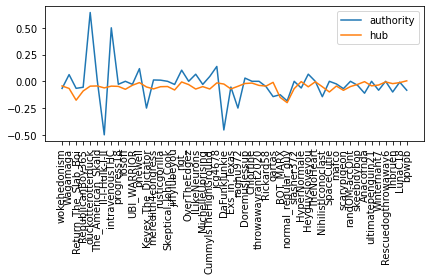

In [241]:
indegree_hub_auth.plot(y=['authority', 'hub'])

plt.xticks(np.arange(indegree_hub_auth.__len__()), 
           indegree_hub_auth.index,
           rotation=90)
plt.tight_layout()
plt.show()

In [242]:
awards_hub_auth.head()

,hub,authority,awards
Wagamaga,-0.066568,0.062500,15.0
IntrepidOrchid,0.027708,0.140394,7.0
thunder-bug-,-0.062564,-0.076923,6.0
DaFunkJunkie,-0.025552,-0.454545,4.0
tyragos,-0.101648,-0.166667,4.0


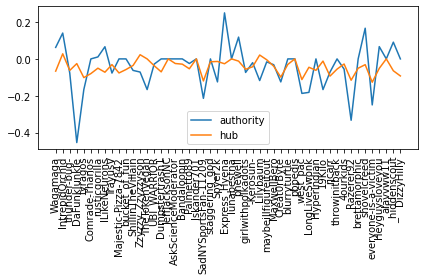

In [243]:
awards_hub_auth.plot(y=['authority', 'hub'])

plt.xticks(np.arange(awards_hub_auth.__len__()), 
           awards_hub_auth.index,
           rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# TODO: 
# 1) udregne forskel mellem author opinion og hub-medlemmer parvist. Beregn et statistisk mål på den forskel. 
#    Dette tjekker hvorvidt en autoritet generelt har samme opinion som medlemmerne af dens hub.
# 2) Brug en statistisk test på tværs af authorities for at se om der er grundlag for at generalisere tendensen.
# 3) EVT) Brug en statistisk test på tværs af hubs (tilknyttet authorities) der sammenligner standard afvigelse 
#    indenfor en hub. Dette vil tjekke om en authority har indflydelse på hvor splittet debatten i hubben er.
# 4) 

In [305]:
import random

k = 10000

graph_copy = ClimateGraph.copy()
graph_copy.to_undirected()
sampled_nodes = random.sample(graph_copy.nodes, k)
graph_copy = graph_copy.subgraph(sampled_nodes)

for k, v in graph_copy.nodes(data=True):
    v['group'] = v['opinion_score']
    v['weights'] = v['score']
    v['size'] = np.nansum([v['num_comments'], v['num_submissions']])
    
    del v['text']
    del v['all_awardings']
    del v['total_awards_received']
    del v['score']
    del v['opinion_score']
    del v['first_comment']
    del v['last_comment']
    del v['first_submission']
    del v['last_submission']
    del v['num_comments']
    del v['num_submissions']
    del v['comment_controversiality']
    del v['tokens']
    del v['processed_text']
    del v['group']

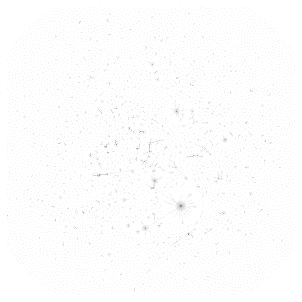

In [306]:
# plot graph
network, config = nw.visualize(graph_copy, plot_in_cell_below=False)
fig, ax = nw.draw_netwulf(network)

In [308]:
os.getcwd()

'/Users/Olivia/Downloads/Reddit-ClimateGraph'

In [312]:
# save graph as json
from networkx.readwrite import json_graph
import json

# specify save location
filename = Path(os.getcwd()) / f'ClimateGraph_{year}.json'
data = json_graph.node_link_data(ClimateGraph)

with open(filename, 'w') as fp:
    json.dump(data, fp)

In [ ]:
ClimateGraph = read_json_file('/Users/Olivia/Downloads/Reddit-ClimateGraph/data/2020/ClimateGraph_2020.json')

authority value --> estimates the value of the content of the page

hub value --> estimates the value of its links to other pages.